# Obtain your API key

You can access your Materials Project API key at https://next-gen.materialsproject.org/api

If you do not have an account yet, you will see the following button.
Simply click it and follow the instructions to obtain your API key.
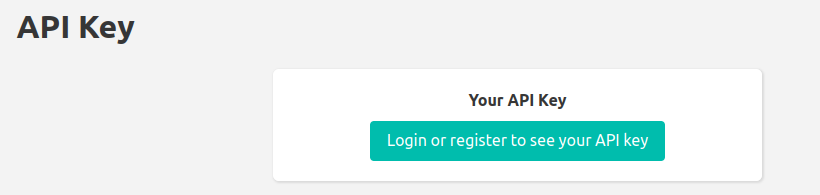


In [ ]:
API_KEY = "[YOUR API KEY]"

These packages heavily depend on the `pymatgen` package so please first follow the instructions [here](https://pymatgen.org/installation.html) to install pymatgen (it is recommended that you set up a virtual environment using `conda` as part of this process).

Instructions for installing and setting up the `Jupyter` notebook environment can be found [here](https://jupyter.org/install)

Then you should install the following two packages:

```
pip install -U mp-api
pip install -U mp-pyrho
```

To test that the installation was completed properly run the following commands and the output should be `pymatgen.io.vasp.outputs.Chgcar`

In [ ]:
from mp_api import MPRester
with MPRester(API_KEY) as mpr:
    chgcar = mpr.get_charge_density_from_material_id("mp-145")
type(chgcar)

# Querying for the charge density of many different structures

The `mp_api` is a full-featured REST api for all of the data on the materials project.
Its features are too numerous to list here, so we will use a basic cystal-system query to show how you can obtain all of the charge densities of the stable structures in the "Hexagonal" crystal system.

We can begin be querying for all of the stable materials in that system.
But since we are not interested in obtaining all of the material data available we can filter our query by the `material_id` field to reduce the time and network load.


In [ ]:
from mp_api import MPRester
with MPRester(API_KEY) as mpr:
    hexagonal_materials = mpr.query(crystal_system="Hexagonal", is_stable=True, fields=["material_id"])

We can see how many documents were returned by the query above.

In [ ]:
print(f"The query returned {len(hexagonal_materials)} documents.")

This returns a list of more than 3000 materials which is much larger, some will have charge densities available in our database some will not.
We can loop through these materials and save the charge densities we find in a folder.

In [1]:
# Create the destination folder if it is not already present
import os
if not os.path.exists('found_chgcars'):
    os.makedirs('found_chgcars')

Finally, we can loop through the different hexagonal materials and grab the charge densities in the form of a `Chgcar`.
Each `Chgcar` object is then written to a file with the name like `CHGCAR_mp-5620.vasp`.
The charge density can be viewed in Vesta and after adjusting the isosurface you should see something like this:

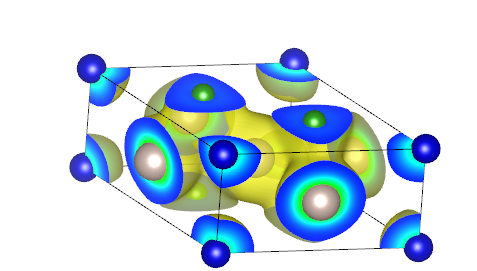


In [ ]:
found_chgcar_ids = []
with MPRester(API_KEY) as mpr:
    for imat in hexagonal_materials[:10]:
        print(f"Searching for {imat.material_id}")
        chgcar = mpr.get_charge_density_from_material_id(imat.material_id)
        if chgcar is None:
            continue
        chgcar.write_file(f"./found_chgcars/CHGCAR_{imat.material_id}.vasp")
        found_chgcar_ids.append(imat.material_id)
